In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_tweets.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [44]:
comb = train.append(test,ignore_index=True)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [45]:
#Here findall function will find all the occurences of pattern into a list
#sub function will replace each occurence with another pattern in string
def remove_pattern(txt,pattern):
    r = re.findall(pattern,txt)
    for i in r:
        txt = re.sub(i,'',txt)
    return txt

In [46]:
#remove twitter handlers
comb['tidy_tweet'] = np.vectorize(remove_pattern)(comb['tweet'], "@[\w]*")

In [47]:
#remove special characters, numbers, punctuations
comb['tidy_tweet'] = comb['tidy_tweet'].str.replace("[^a-zA-Z0-9#]"," ")

In [48]:
#remove short words as they give very little info
comb['tidy_tweet'] = comb['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [49]:
comb.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [50]:
#tokenization
token = comb['tidy_tweet'].apply(lambda x:x.split())
token.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [51]:
#stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

token = token.apply(lambda x: [stemmer.stem(i) for i in x])
token.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [52]:
for i in range(len(token)):
    token[i] = ' '.join(token[i])
comb['tidy_tweet'] = token

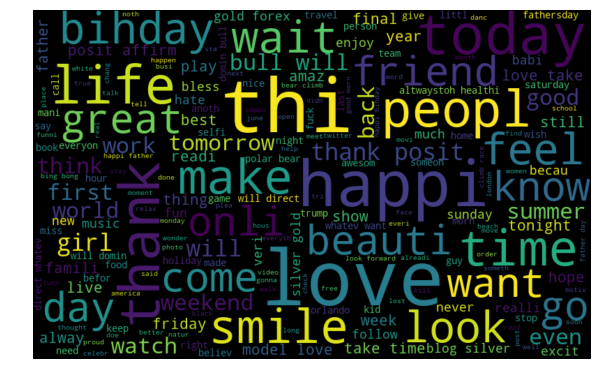

In [53]:
all_words = ' '.join([text for text in comb['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

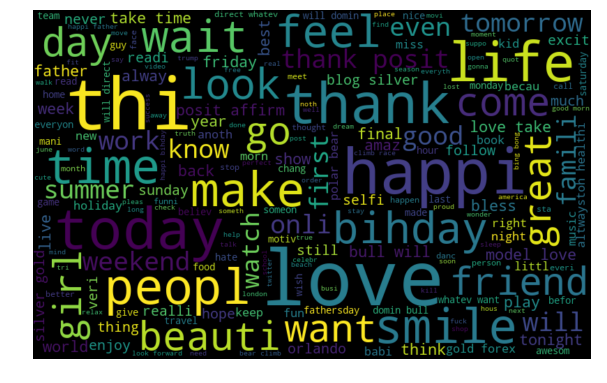

In [56]:
# Non Racist/Sexist tweets
normal_words =' '.join([text for text in comb['tidy_tweet'][comb['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

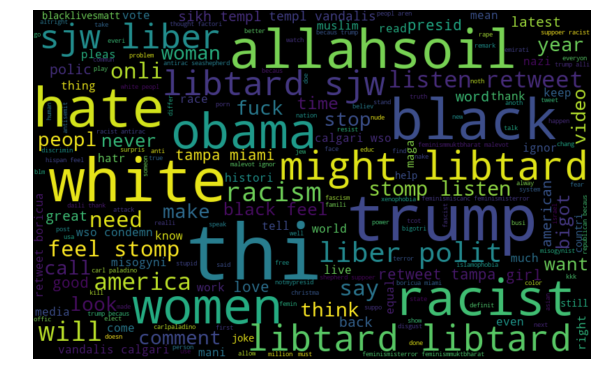

In [57]:
# Racist/Sexist tweets
negative_words = ' '.join([text for text in comb['tidy_tweet'][comb['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [59]:
# hashtags are the current trend
def hashtag(x):
    hashtags=[]
    for i in x:
        hsh = re.findall(r"#(\w+)",i)
        hashtags.append(hsh)
    return hashtags

In [60]:
hsh_pos = hashtag(comb['tidy_tweet'][comb['label']==0])
hsh_neg = hashtag(comb['tidy_tweet'][comb['label']==1])

# unnesting list
hsh_pos = sum(hsh_pos,[])
hsh_neg = sum(hsh_neg,[])

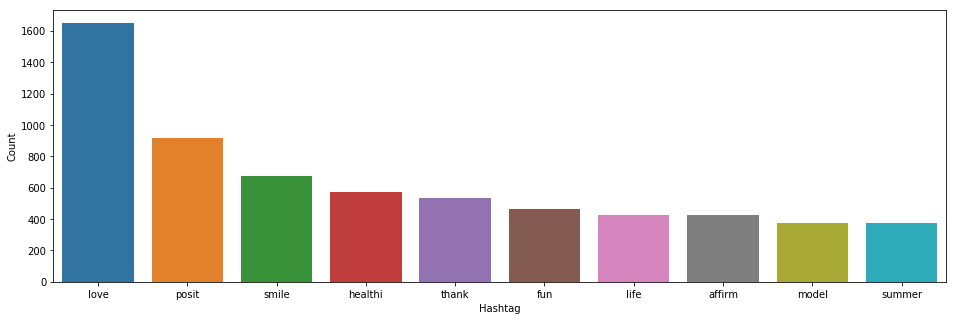

In [63]:
# Positive Hashtags
a = nltk.FreqDist(hsh_pos)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                  'Count':list(a.values())})

d = d.nlargest(columns="Count",n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel='Count')
plt.show()

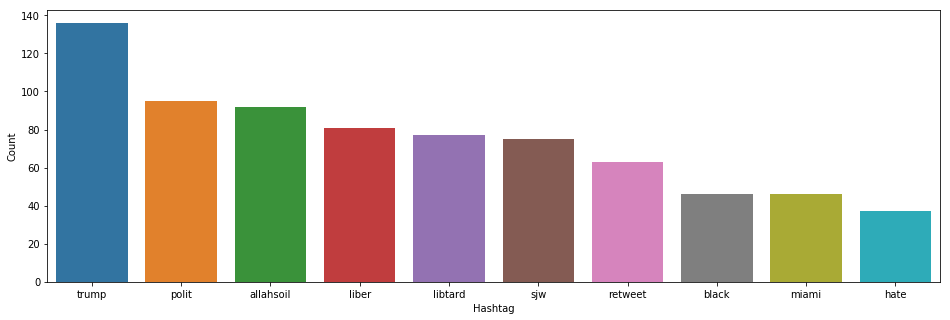

In [64]:
# Negative hashtags
a = nltk.FreqDist(hsh_neg)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                  'Count':list(a.values())})

d = d.nlargest(columns="Count",n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel='Count')
plt.show()

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(comb['tidy_tweet'])

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(comb['tidy_tweet'])

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.550413223140496

In [69]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('ans.csv', index=False) # writing data to a CSV file

In [70]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5564304461942257